<h1 style="color:#2E86C1; text-align:center;"> Group 43 - Distributed Machine Learning</h1>
<h2 style="color:#117864;">Assignment 02: Contributions</h2>

<table style="border-collapse: collapse; width: 100%; font-size: 16px;">
  <thead>
    <tr style="background-color: #D6EAF8;">
      <th style="border: 1px solid #ABB2B9; padding: 8px;">👤 Name</th>
      <th style="border: 1px solid #ABB2B9; padding: 8px;">🆔 BITS ID</th>
      <th style="border: 1px solid #ABB2B9; padding: 8px;">📈 Contribution</th>
    </tr>
  </thead>
  <tbody>
    <tr style="background-color: #FDFEFE;">
      <td style="border: 1px solid #ABB2B9; padding: 8px;">SUBHRANSU MISHRA</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">2023AC05489</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">✅ 100%</td>
    </tr>
    <tr style="background-color: #F8F9F9;">
      <td style="border: 1px solid #ABB2B9; padding: 8px;">DULAL DAS</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">2023AC05041</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">✅ 100%</td>
    </tr>
    <tr style="background-color: #FDFEFE;">
      <td style="border: 1px solid #ABB2B9; padding: 8px;">LAKSHMISRINIVAS PERAKAM </td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">2023AC05540</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">✅ 100%</td>
    </tr>
    <tr style="background-color: #F8F9F9;">
      <td style="border: 1px solid #ABB2B9; padding: 8px;">ARCHAN GHOSH</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">2023AC05402</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">✅ 100%</td>
    </tr>
  </tbody>
</table>

<p style="text-align:center; font-size: 14px; color:gray; margin-top:20px;">
Each member contributed equally towards the completion of this assignment.
</p>


In [1]:
!unzip "/content/default+of+credit+card+clients.zip"

unzip:  cannot find or open /content/default+of+credit+card+clients.zip, /content/default+of+credit+card+clients.zip.zip or /content/default+of+credit+card+clients.zip.ZIP.


In [11]:
### =======================================================================
### PART 1: SETUP AND IMPORTS
### =======================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    normalized_mutual_info_score,
    silhouette_score,
)
from sklearn.calibration import calibration_curve

from sklearn.inspection import permutation_importance
from warnings import filterwarnings
from sklearn.exceptions import ConvergenceWarning

# Make outputs reproducible
np.random.seed(42)

# Keep sklearn/MLP chatter down in the notebook
filterwarnings('ignore', category=UserWarning, module='sklearn')
filterwarnings('ignore', category=ConvergenceWarning, module='sklearn')

# Optional: nicer pandas display in notebooks (safe)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

In [12]:
### =======================================================================
### PART 2: DATA LOADING AND PREPARATION
### =======================================================================
from IPython.display import display

print("--- 1. Loading and Preparing Data ---")
try:
    df = pd.read_excel('default_of_credit_card_clients.xls', header=1)
    if 'ID' in df.columns:
        df = df.drop(columns=['ID'])
    if 'default payment next month' in df.columns:
        df = df.rename(columns={'default payment next month': 'DEFAULT'})
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: file 'default_of_credit_card_clients.xls' not found.")
    raise SystemExit(1)

# Split vertically for clients and server
client_A_features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
client_B_features = [col for col in df.columns if col.startswith(('PAY_', 'BILL_AMT', 'PAY_AMT'))]
server_label = ['DEFAULT']

client_A_data = df[client_A_features]
client_B_data = df[client_B_features]
server_labels = df[server_label]

print("Data split successfully!")

# --- Client A (demographics & credit)
print("\nClient A's Data (Demographics & Credit):")
print(f"Shape: {client_A_data.shape}")
display(client_A_data.head())

# --- Client B (payment & bill history)
print("\nClient B's Data (Payment & Bill History):")
print(f"Shape: {client_B_data.shape}")
display(client_B_data.head())

# --- Server labels
print("\nServer's Labels:")
print(f"Shape: {server_labels.shape}")
display(server_labels.head())

# =======================================================================
# Extra STATS & sanity checks
# =======================================================================
print("\n--- Dataset overview ---")
print("Rows, Cols:", df.shape)
display(df.describe(include='all').T)

print("\n--- Missing values ---")
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if not missing.empty:
    display(missing.to_frame("n_missing"))
else:
    print("No missing values detected.")

print("\n--- Target distribution ---")
vc = server_labels['DEFAULT'].value_counts().sort_index()
total = int(vc.sum())
target_stats = pd.DataFrame({
    "Class": vc.index,
    "Count": vc.values,
    "Percent": (vc.values / total * 100).round(2)
})
display(target_stats)

print("\n--- Feature groups ---")
print(f"Client A features: {len(client_A_features)} -> {client_A_features}")
print(f"Client B features: {len(client_B_features)}")
print(f"Total features: {len(client_A_features) + len(client_B_features)}")

# Cache mean values for drift checks later
_baseline_moments = {
    "A_mean": client_A_data.mean(numeric_only=True),
    "B_mean": client_B_data.mean(numeric_only=True),
}

--- 1. Loading and Preparing Data ---
Dataset loaded successfully.
Data split successfully!

Client A's Data (Demographics & Credit):
Shape: (30000, 5)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
0,20000,2,2,1,24
1,120000,2,2,2,26
2,90000,2,2,2,34
3,50000,2,2,1,37
4,50000,1,2,1,57



Client B's Data (Payment & Bill History):
Shape: (30000, 18)


,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679



Server's Labels:
Shape: (30000, 1)


,DEFAULT
0,1
1,1
2,0
3,0
4,0



--- Dataset overview ---
Rows, Cols: (30000, 24)


,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0



--- Missing values ---
No missing values detected.

--- Target distribution ---


,Class,Count,Percent
0,0,23364,77.88
1,1,6636,22.12



--- Feature groups ---
Client A features: 5 -> ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
Client B features: 18
Total features: 23


In [13]:
client_A_data = df[client_A_features]
client_B_data = df[client_B_features]
server_labels = df[server_label]


print("Data split successfully!")

print("\nClient A's Data (Demographics & Credit):")
print(f"Shape: {client_A_data.shape}")
display(client_A_data.head())

print("\nClient B's Data (Payment & Bill History):")
print(f"Shape: {client_B_data.shape}")
display(client_B_data.head())

print("\nServer's Labels:")
print(f"Shape: {server_labels.shape}")
display(server_labels.head())

Data split successfully!

Client A's Data (Demographics & Credit):
Shape: (30000, 5)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
0,20000,2,2,1,24
1,120000,2,2,2,26
2,90000,2,2,2,34
3,50000,2,2,1,37
4,50000,1,2,1,57



Client B's Data (Payment & Bill History):
Shape: (30000, 18)


,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679



Server's Labels:
Shape: (30000, 1)


,DEFAULT
0,1
1,1
2,0
3,0
4,0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Split into train/test
client_A_train, client_A_test, client_B_train, client_B_test, server_labels_train, server_labels_test = train_test_split(
    client_A_data,
    client_B_data,
    server_labels,
    test_size=0.2,
    random_state=42,
    stratify=server_labels  # ensures target balance in both sets
)

# Scale features for both clients
scaler_A = StandardScaler()
client_A_train_scaled = scaler_A.fit_transform(client_A_train)
client_A_test_scaled = scaler_A.transform(client_A_test)

scaler_B = StandardScaler()
client_B_train_scaled = scaler_B.fit_transform(client_B_train)
client_B_test_scaled = scaler_B.transform(client_B_test)

print("Data prepared and scaled.\n")

# =======================================================================
# Extra STATS: sanity checks & drift
# =======================================================================

# Show shapes of splits
print("\n--- Split Overview ---")
print(f"Client A -> train: {client_A_train.shape}, test: {client_A_test.shape}")
print(f"Client B -> train: {client_B_train.shape}, test: {client_B_test.shape}")
print(f"Server labels -> train: {server_labels_train.shape}, test: {server_labels_test.shape}")

# Check class distribution in train vs test
train_dist = server_labels_train['DEFAULT'].value_counts(normalize=True) * 100
test_dist = server_labels_test['DEFAULT'].value_counts(normalize=True) * 100
print("\n--- Target Class Distribution ---")
print("Train:")
print(train_dist.round(2))
print("Test:")
print(test_dist.round(2))

# Mean/std sanity for scaled data
def check_scaling(name, arr):
    mean_val = np.mean(arr, axis=0).mean()
    std_val = np.std(arr, axis=0).mean()
    print(f"{name} -> avg mean: {mean_val:.4f}, avg std: {std_val:.4f}")

print("\n--- Scaling Sanity Check ---")
check_scaling("Client A (train)", client_A_train_scaled)
check_scaling("Client A (test)", client_A_test_scaled)
check_scaling("Client B (train)", client_B_train_scaled)
check_scaling("Client B (test)", client_B_test_scaled)

# Drift check: compare mean difference from original baseline means
try:
    drift_A = (client_A_test.mean(numeric_only=True) - _baseline_moments['A_mean']).abs()
    drift_B = (client_B_test.mean(numeric_only=True) - _baseline_moments['B_mean']).abs()
    print("\n--- Top Feature Drift (Test vs Full Dataset) ---")
    print("Client A:")
    display(drift_A.sort_values(ascending=False).head(5).to_frame("abs_diff"))
    print("Client B:")
    display(drift_B.sort_values(ascending=False).head(5).to_frame("abs_diff"))
except Exception as e:
    print("\nDrift check skipped (baseline moments missing).")

Data prepared and scaled.


--- Split Overview ---
Client A -> train: (24000, 5), test: (6000, 5)
Client B -> train: (24000, 18), test: (6000, 18)
Server labels -> train: (24000, 1), test: (6000, 1)

--- Target Class Distribution ---
Train:
DEFAULT
0    77.88
1    22.12
Name: proportion, dtype: float64
Test:
DEFAULT
0    77.88
1    22.12
Name: proportion, dtype: float64

--- Scaling Sanity Check ---
Client A (train) -> avg mean: 0.0000, avg std: 1.0000
Client A (test) -> avg mean: 0.0018, avg std: 1.0022
Client B (train) -> avg mean: 0.0000, avg std: 1.0000
Client B (test) -> avg mean: 0.0075, avg std: 1.0672

--- Top Feature Drift (Test vs Full Dataset) ---
Client A:


,abs_diff
LIMIT_BAL,478.624000
AGE,0.211500
SEX,0.004067
MARRIAGE,0.004033
EDUCATION,0.002633


Client B:


,abs_diff
BILL_AMT6,783.122100
BILL_AMT2,667.230333
BILL_AMT3,605.098867
BILL_AMT5,587.953367
BILL_AMT1,491.314600


In [15]:
### =======================================================================
### PART 3: FINAL CLASS DEFINITIONS
### =======================================================================

class VFLClient:
    """Represents a client in the VFL system."""
    def __init__(self, name, data_for_init, n_features_out=32):
        self.name = name
        self.model = MLPClassifier(
            hidden_layer_sizes=(64, n_features_out),
            max_iter=10,
            warm_start=True,
            random_state=42
        )
        # Initialize with dummy labels to set up internal weights
        self.model.fit(data_for_init, np.zeros(data_for_init.shape[0]))

    def generate_representations(self, input_data):
        # Uses internal fast forward pass as in your original code
        return self.model._forward_pass_fast(input_data)

    def create_pseudo_labels(self, gradients, n_classes):
        # Use fixed n_init for broad sklearn version compatibility
        kmeans = KMeans(n_clusters=n_classes, random_state=42, n_init=10)
        self.pseudo_labels = kmeans.fit_predict(gradients)
        return self.pseudo_labels

    def local_train(self, data):
        self.model.fit(data, self.pseudo_labels)


class VFLServer:
    """Represents the server that coordinates training."""
    def __init__(self, n_classes):
        self.model = MLPClassifier(
            hidden_layer_sizes=(64,),
            max_iter=5,
            warm_start=True,
            random_state=42
        )
        self.n_classes = n_classes
        self._last_eval = None  # for later summary/plots

    def combine_and_train(self, reps_A, reps_B, labels):
        self.combined_reps_train = np.concatenate((reps_A, reps_B), axis=1)
        self.model.fit(self.combined_reps_train, labels.values.ravel())

    def compute_and_distribute_gradients(self, reps_A_shape):
        # Simulated gradient prototypes per class (as in your original idea)
        prototype_gradients = np.random.rand(self.n_classes, self.combined_reps_train.shape[1])
        predictions = self.model.predict(self.combined_reps_train)
        simulated_gradients = np.array([prototype_gradients[pred] for pred in predictions])

        split_point = reps_A_shape[1]
        grad_for_A = simulated_gradients[:, :split_point]
        grad_for_B = simulated_gradients[:, split_point:]
        return grad_for_A, grad_for_B

    def evaluate(self, reps_A_test, reps_B_test, true_labels_test):
        combined_test_reps = np.concatenate((reps_A_test, reps_B_test), axis=1)
        predictions = self.model.predict(combined_test_reps)
        accuracy = accuracy_score(true_labels_test, predictions)

        # Extra: probability-based metrics if available
        try:
            proba = self.model.predict_proba(combined_test_reps)[:, 1]
        except Exception:
            proba = None

        if proba is not None:
            try:
                auc = roc_auc_score(true_labels_test, proba)
            except Exception:
                auc = None
        else:
            auc = None

        # Confusion matrix
        try:
            cm = confusion_matrix(true_labels_test, predictions)
        except Exception:
            cm = None

        report = classification_report(true_labels_test, predictions)

        # Prints (keeps your original output and adds AUC + CM)
        print("\n--- Final Model Evaluation ---")
        print(f"Final Model Accuracy: {accuracy:.4f}")
        if auc is not None:
            print(f"ROC-AUC: {auc:.4f}")
        print("\nClassification Report:")
        print(report)
        if cm is not None:
            print("Confusion Matrix:\n", cm)

        # Cache & return for later notebook cells
        self._last_eval = {
            "accuracy": float(accuracy),
            "roc_auc": float(auc) if auc is not None else None,
            "confusion_matrix": cm,
            "predictions": predictions,
            "proba": proba,
        }
        return self._last_eval


Starting One-Shot VFL Simulation ---
Clients generated initial representations.
Representation generation time: 0.009s

--- Representation shapes (train) ---
reps_A_train: (24000, 1)
reps_B_train: (24000, 1)
concat: (24000, 2)
Server trained and distributed gradients.
Server train + gradient time: 0.094s

Clients created pseudo-labels via clustering.
NMI between Client-A and Client-B pseudo-labels: 1.000
Client-A pseudo-label balance: {np.int32(0): np.int64(24000)}
Client-B pseudo-label balance: {np.int32(0): np.int64(24000)}

Clients completed local training.
Local training time (both): 0.372s
--- One-Shot VFL Simulation Complete ---

Evaluating Final Model on Test Data ---

--- Final Model Evaluation ---
Final Model Accuracy: 0.7788
ROC-AUC: 0.6400

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      60

,Metric,Value
0,Accuracy,0.778833
1,ROC-AUC,0.640033


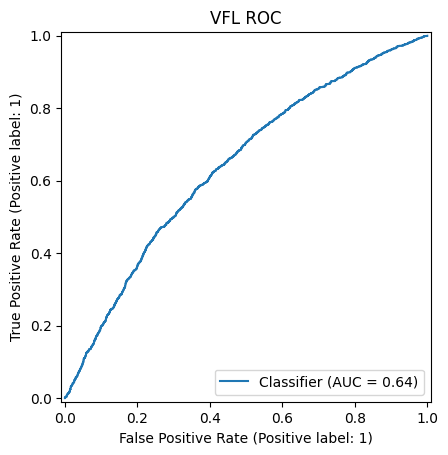

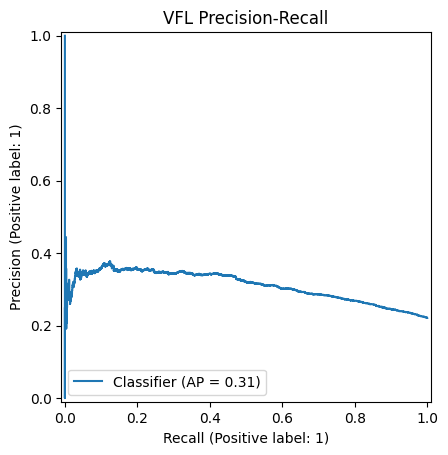

In [16]:
### =======================================================================
### PART 4: SIMULATION EXECUTION
### =======================================================================
from IPython.display import display
import pandas as pd
import time

print("Starting One-Shot VFL Simulation ---")

# Instantiate clients and server
client_A = VFLClient(name="Client A", data_for_init=client_A_train_scaled)
client_B = VFLClient(name="Client B", data_for_init=client_B_train_scaled)
n_classes = len(server_labels['DEFAULT'].unique())
server = VFLServer(n_classes=n_classes)

# Generate initial representations (timed)
_t0 = time.perf_counter()
reps_A_train = client_A.generate_representations(client_A_train_scaled)
reps_B_train = client_B.generate_representations(client_B_train_scaled)
t_gen = time.perf_counter() - _t0
print("Clients generated initial representations.")
print(f"Representation generation time: {t_gen:.3f}s")

# Shapes for clarity
print("\n--- Representation shapes (train) ---")
print("reps_A_train:", reps_A_train.shape)
print("reps_B_train:", reps_B_train.shape)
print("concat:", (reps_A_train.shape[0], reps_A_train.shape[1] + reps_B_train.shape[1]))

# Server combine/train + gradient distribution (timed)
_t1 = time.perf_counter()
server.combine_and_train(reps_A_train, reps_B_train, server_labels_train)
grads_A, grads_B = server.compute_and_distribute_gradients(reps_A_train.shape)
t_server = time.perf_counter() - _t1
print("Server trained and distributed gradients.")
print(f"Server train + gradient time: {t_server:.3f}s")

# Clients create pseudo-labels
client_A.create_pseudo_labels(grads_A, n_classes)
client_B.create_pseudo_labels(grads_B, n_classes)
print("\nClients created pseudo-labels via clustering.")
try:
    # Optional: agreement / balance stats
    from sklearn.metrics import normalized_mutual_info_score
    nmi = normalized_mutual_info_score(client_A.pseudo_labels, client_B.pseudo_labels)
    print(f"NMI between Client-A and Client-B pseudo-labels: {nmi:.3f}")
    # Simple balance view
    uniqA, cntA = np.unique(client_A.pseudo_labels, return_counts=True)
    uniqB, cntB = np.unique(client_B.pseudo_labels, return_counts=True)
    print("Client-A pseudo-label balance:", dict(zip(uniqA, cntA)))
    print("Client-B pseudo-label balance:", dict(zip(uniqB, cntB)))
except Exception:
    pass

# Clients local training (timed)
_t2 = time.perf_counter()
client_A.local_train(client_A_train_scaled)
client_B.local_train(client_B_train_scaled)
t_local = time.perf_counter() - _t2
print("\nClients completed local training.")
print(f"Local training time (both): {t_local:.3f}s")
print("--- One-Shot VFL Simulation Complete ---\n")

# Evaluate on test data
print("Evaluating Final Model on Test Data ---")
reps_A_test = client_A.generate_representations(client_A_test_scaled)
reps_B_test = client_B.generate_representations(client_B_test_scaled)
eval_out = server.evaluate(reps_A_test, reps_B_test, server_labels_test)

# Compact results table for the notebook
try:
    summary = pd.DataFrame(
        [{"Metric": "Accuracy", "Value": eval_out.get("accuracy")},
         {"Metric": "ROC-AUC", "Value": eval_out.get("roc_auc")}]
    )
    print("\n--- Summary ---")
    display(summary)
except Exception:
    pass

# Optional: quick ROC/PR plots if probabilities exist (safe no-op otherwise)
try:
    if eval_out.get("proba") is not None:
        RocCurveDisplay.from_predictions(server_labels_test.values.ravel(), eval_out["proba"])
        plt.title("VFL ROC"); plt.show()

        PrecisionRecallDisplay.from_predictions(server_labels_test.values.ravel(), eval_out["proba"])
        plt.title("VFL Precision-Recall"); plt.show()
except Exception:
    pass


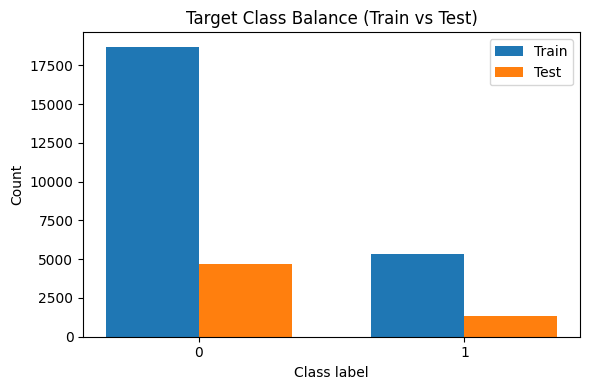

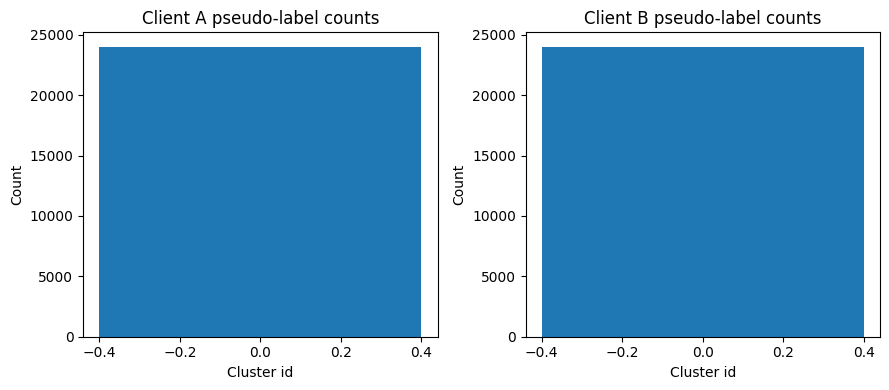

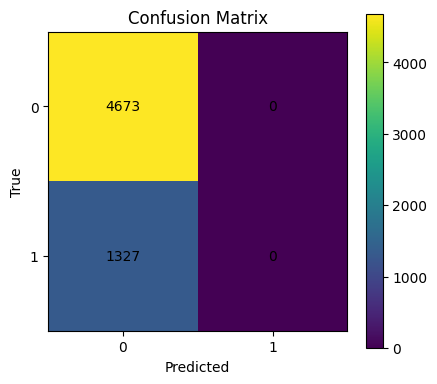

ROC-AUC (test): 0.6400


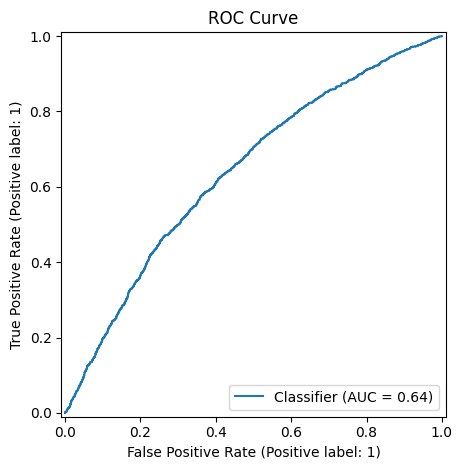

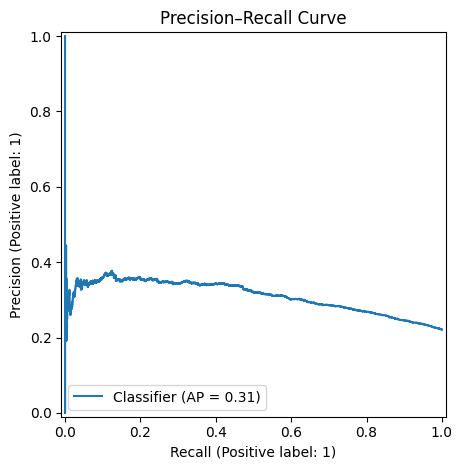

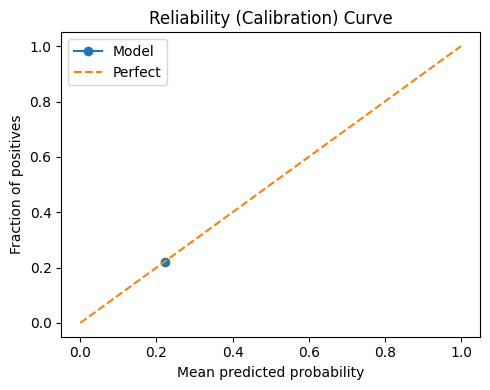

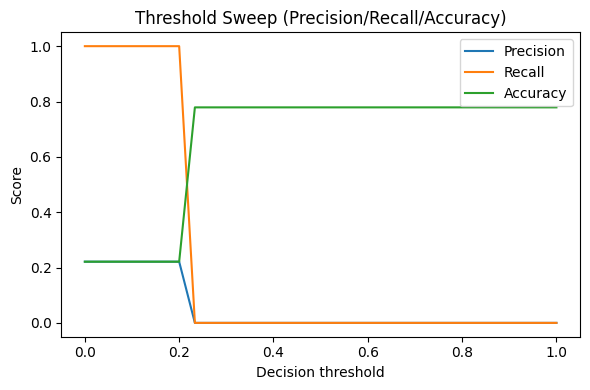

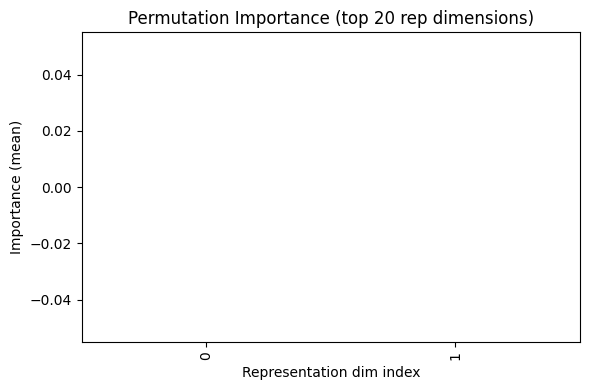


[Part 5 done] Plots rendered above. You can collapse/expand cells as needed.


In [17]:
### =======================================================================
### PART 5: VISUAL METRICS & GRAPHS
### =======================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_recall_fscore_support,
    roc_auc_score,
)

# calibration_curve moved in newer sklearn versions
try:
    from sklearn.calibration import calibration_curve
except ImportError:
    from sklearn.metrics import calibration_curve  # for older sklearn

# ---------------------------
# Helpers
# ---------------------------
def plot_confusion_matrix(y_true, y_pred, labels=(0,1), title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(4.5,4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    return cm

def plot_calibration_curve(y_true, proba, n_bins=10, title="Reliability (Calibration) Curve"):
    frac_pos, mean_pred = calibration_curve(y_true, proba, n_bins=n_bins, strategy="uniform")
    plt.figure(figsize=(5,4))
    plt.plot(mean_pred, frac_pos, marker="o", linewidth=1.5, label="Model")
    plt.plot([0,1],[0,1], "--", label="Perfect")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_pr_and_roc(y_true, proba):
    # ROC
    RocCurveDisplay.from_predictions(y_true, proba)
    plt.title("ROC Curve")
    plt.tight_layout()
    plt.show()

    # PR
    PrecisionRecallDisplay.from_predictions(y_true, proba)
    plt.title("Precision–Recall Curve")
    plt.tight_layout()
    plt.show()

def plot_threshold_sweep(y_true, proba, n_points=30):
    """Precision/Recall/Accuracy vs decision threshold."""
    thresholds = np.linspace(0.0, 1.0, n_points)
    precs, recs, accs = [], [], []
    for t in thresholds:
        y_hat = (proba >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
        acc = (y_hat == y_true).mean()
        precs.append(p); recs.append(r); accs.append(acc)

    plt.figure(figsize=(6,4))
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, accs, label="Accuracy")
    plt.xlabel("Decision threshold")
    plt.ylabel("Score")
    plt.title("Threshold Sweep (Precision/Recall/Accuracy)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def safe_get_eval():
    # Prefer the latest eval dict from Part 4, else the cached server._last_eval
    if 'eval_out' in globals() and isinstance(eval_out, dict):
        return eval_out
    return getattr(server, "_last_eval", None)

# ---------------------------
# 5.1 Class balance (train vs test) — quick bar chart
# ---------------------------
try:
    train_counts = server_labels_train['DEFAULT'].value_counts().sort_index()
    test_counts  = server_labels_test['DEFAULT'].value_counts().sort_index()
    idx = sorted(set(train_counts.index).union(test_counts.index))
    train_vals = [int(train_counts.get(i, 0)) for i in idx]
    test_vals  = [int(test_counts.get(i, 0)) for i in idx]

    x = np.arange(len(idx))
    width = 0.35
    plt.figure(figsize=(6,4))
    plt.bar(x - width/2, train_vals, width, label="Train")
    plt.bar(x + width/2, test_vals,  width, label="Test")
    plt.xticks(x, idx)
    plt.title("Target Class Balance (Train vs Test)")
    plt.xlabel("Class label")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass

# ---------------------------
# 5.2 Pseudo-label balance for each client (after clustering)
# ---------------------------
try:
    uniqA, cntA = np.unique(client_A.pseudo_labels, return_counts=True)
    uniqB, cntB = np.unique(client_B.pseudo_labels, return_counts=True)

    fig, axes = plt.subplots(1, 2, figsize=(9,4))
    axes[0].bar(uniqA, cntA)
    axes[0].set_title("Client A pseudo-label counts")
    axes[0].set_xlabel("Cluster id"); axes[0].set_ylabel("Count")

    axes[1].bar(uniqB, cntB)
    axes[1].set_title("Client B pseudo-label counts")
    axes[1].set_xlabel("Cluster id"); axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()
except Exception:
    pass

# ---------------------------
# 5.3 Confusion Matrix, ROC, PR, Calibration (if proba available)
# ---------------------------
_e = safe_get_eval()
if _e is not None:
    y_true = server_labels_test.values.ravel()
    y_pred = _e.get("predictions", None)
    proba  = _e.get("proba", None)

    if y_pred is not None:
        _ = plot_confusion_matrix(y_true, y_pred, labels=(0,1))

    if proba is not None:
        # ROC-AUC
        try:
            auc = roc_auc_score(y_true, proba)
            print(f"ROC-AUC (test): {auc:.4f}")
        except Exception:
            pass

        plot_pr_and_roc(y_true, proba)
        plot_calibration_curve(y_true, proba, n_bins=10)

        # Threshold sweep
        plot_threshold_sweep(y_true, proba, n_points=31)

# ---------------------------
# 5.4 (Optional) Permutation importance on representations
#      Shows which combined-representation dimensions matter.
# ---------------------------
try:
    from sklearn.inspection import permutation_importance

    # Build combined test reps (same as in VFLServer.evaluate)
    reps_A_test_opt = client_A.generate_representations(client_A_test_scaled)
    reps_B_test_opt = client_B.generate_representations(client_B_test_scaled)
    X_rep_test = np.concatenate((reps_A_test_opt, reps_B_test_opt), axis=1)
    y_rep_test = server_labels_test.values.ravel()

    # If server.model is sklearn MLP, we can run permutation importance
    result = permutation_importance(server.model, X_rep_test, y_rep_test, n_repeats=5, random_state=42)
    imp = pd.Series(result.importances_mean)
    topk = imp.abs().sort_values(ascending=False).head(20)
    plt.figure(figsize=(6,4))
    topk.plot(kind="bar")
    plt.title("Permutation Importance (top 20 rep dimensions)")
    plt.xlabel("Representation dim index")
    plt.ylabel("Importance (mean)")
    plt.tight_layout()
    plt.show()
except Exception:
    pass

print("\n[Part 5 done] Plots rendered above. You can collapse/expand cells as needed.")
